In [118]:
import numpy as np 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator


In [68]:
# load
df = pd.read_pickle("../output/data/scaled_train_nonoverlap_top_10_store_item_X_y.pkl")
df.head()

,date,store_item,item_nbr,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,sales_day_6,sales_day_7,...,y_store_med_day_5,y_store_med_day_6,y_store_med_day_7,y_item_med_day_1,y_item_med_day_2,y_item_med_day_3,y_item_med_day_4,y_item_med_day_5,y_item_med_day_6,y_item_med_day_7
9,2013-01-07,3_1047679,1047679,0.458730,0.073355,0.098931,0.201942,0.392058,0.811775,0.642623,...,0.248855,0.293631,0.373440,0.655298,0.424149,0.176024,0.202652,0.437086,0.675746,0.711467
109,2013-01-14,3_1047679,1047679,0.370635,0.099245,0.067611,0.029903,0.287365,0.652988,0.554918,...,0.233335,0.264983,0.296819,0.434836,0.191950,0.206373,0.272727,0.214570,0.282750,0.514180
209,2013-01-21,3_1047679,1047679,0.461111,0.074649,0.086751,0.156117,0.161733,0.463872,0.388525,...,0.379813,0.355046,0.342084,0.080390,0.199690,0.147193,0.196970,0.209272,0.363165,0.329223
309,2013-01-28,3_1047679,1047679,0.199206,0.065156,0.071588,0.128932,0.391336,0.333631,0.526230,...,0.225370,0.306709,0.184635,0.225335,0.202786,0.209408,0.225379,0.182781,0.225681,0.124538
409,2013-02-04,3_1047679,1047679,0.247619,0.076160,0.065374,0.104854,0.340072,0.325602,0.200820,...,0.309908,0.354130,0.308045,0.152253,0.241486,0.210926,0.170455,0.135099,0.172503,0.186190


In [69]:
df.columns

Index(['date', 'store_item', 'item_nbr', 'sales_day_1', 'sales_day_2',
       'sales_day_3', 'sales_day_4', 'sales_day_5', 'sales_day_6',
       'sales_day_7', 'store_med_day_1', 'store_med_day_2', 'store_med_day_3',
       'store_med_day_4', 'store_med_day_5', 'store_med_day_6',
       'store_med_day_7', 'item_med_day_1', 'item_med_day_2', 'item_med_day_3',
       'item_med_day_4', 'item_med_day_5', 'item_med_day_6', 'item_med_day_7',
       'y_sales_day_1', 'y_sales_day_2', 'y_sales_day_3', 'y_sales_day_4',
       'y_sales_day_5', 'y_sales_day_6', 'y_sales_day_7', 'y_store_med_day_1',
       'y_store_med_day_2', 'y_store_med_day_3', 'y_store_med_day_4',
       'y_store_med_day_5', 'y_store_med_day_6', 'y_store_med_day_7',
       'y_item_med_day_1', 'y_item_med_day_2', 'y_item_med_day_3',
       'y_item_med_day_4', 'y_item_med_day_5', 'y_item_med_day_6',
       'y_item_med_day_7'],
      dtype='object')

In [70]:
feature_cols = (
    [f"sales_day_{i}"     for i in range(1, 8)]  # 7 cols
  + [f"store_med_day_{i}" for i in range(1, 8)]  # 7 cols
  + [f"item_med_day_{i}"  for i in range(1, 8)]  # 7 cols
)
label_cols = (
    [f"y_sales_day_{i}"     for i in range(1,8)]
  + [f"y_store_med_day_{i}" for i in range(1,8)]
  + [f"y_item_med_day_{i}"  for i in range(1,8)]
)
# … shift & drop to build X, y …
df = df.dropna(subset=[f'y_{c}' for c in feat_cols]).reset_index(drop=True)

# now build groups:
groups = df['store_item'].values      # e.g. array(['3_1047679', '5_2093842', …], dtype=object)

# if you really need integer labels, you can factorize:
group_ids, groups_idx = np.unique(groups, return_inverse=True)
# groups_idx is then an array of 0..(num_groups‑1)

X = df[feature_cols].to_numpy()          # shape (N, 21)
y = df[[f"y_{c}" for c in feat_cols]].to_numpy()  # shape (N, 21)

In [71]:
print(X.shape)
print(y.shape)

(23799, 21)
(23799, 21)


In [72]:
groups_idx

array([ 0,  0,  0, ..., 99, 99, 99])

In [73]:
class StoreItemDataset(Dataset):
    def __init__(self, df, store_item_id, feature_cols, target_col, weight_col):
        self.store_df = df[df['store_item'] == store_item_id].reset_index(drop=True)
        self.X = torch.tensor(self.store_df[feature_cols].values, dtype=torch.float32)
        self.y = torch.tensor(self.store_df[target_col].values, dtype=torch.float32).unsqueeze(1)
        self.w = torch.tensor(self.store_df[weight_col].values, dtype=torch.float32).unsqueeze(1)
    
    def __len__(self):
        return len(self.store_df)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.w[idx]

# 2) Define the 3‐layer NN with tanh activations
class ThreeLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        return self.net(x)

# 3) Implement NWRMSLE loss
class NWRMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, y_pred, y_true, w):
        # add 1 to avoid log(0), clamp to eps to keep preds positive
        eps = 1e-6
        y_pred = torch.clamp(y_pred, min=eps)
        log_diff = torch.log(y_pred + 1.0) - torch.log(y_true + 1.0)
        num = torch.sum(w * log_diff**2)
        den = torch.sum(w)
        return torch.sqrt(num / den)

In [95]:

# def make_storeitem_kfold_loaders(
#     df: pd.DataFrame,
#     store_item_id: str,
#     feature_cols: list[str],
#     target_col: str,
#     weight_col: str,
#     k: int = 5,
#     batch_size: int = 64,
#     shuffle: bool = True,
#     seed: int = 42,
# ):
#     """
#     For one `store_item_id`, build its StoreItemDataset and split it into k folds,
#     returning a list of (train_loader, val_loader) pairs.
#     """
#     # 1) Build the per‐store_item dataset
#     full_ds: Dataset = StoreItemDataset(
#         df=df,
#         store_item_id=store_item_id,
#         feature_cols=feature_cols,
#         target_col=target_col,
#         weight_col=weight_col
#     )

#     # 2) Generate shuffled indices
#     n = len(full_ds)
#     idxs = np.arange(n)
#     if shuffle:
#         rng = np.random.RandomState(seed)
#         rng.shuffle(idxs)

#     # 3) Assign to k roughly‑equal folds
#     fold_sizes = [(n // k) + (1 if i < (n % k) else 0) for i in range(k)]
#     folds = []
#     ptr = 0
#     for fs in fold_sizes:
#         folds.append(idxs[ptr:ptr+fs])
#         ptr += fs

#     # 4) Build DataLoaders for each fold
#     loaders = []
#     for i in range(k):
#         val_idx   = folds[i]
#         train_idx = np.hstack([folds[j] for j in range(k) if j != i])

#         train_ds = Subset(full_ds, train_idx)
#         val_ds   = Subset(full_ds, val_idx)

#         train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
#         val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
#         loaders.append((train_loader, val_loader))

#     return loaders


In [ ]:

# def make_storeitem_kfold_loaders(
#     df: pd.DataFrame,
#     store_item_id: str,
#     feature_cols: list[str],
#     label_cols: list[str],
#     k: int = 5,
#     batch_size: int = 64,
#     shuffle: bool = True,
#     seed: int = 42,
# ):
#     """
#     For one `store_item_id`, slice out its rows from `df`, build
#     a TensorDataset(X, y), and split into k folds, returning
#     a list of (train_loader, val_loader) pairs.
#     """
#     # 1) Filter to just this store_item
#     sub = df[df['store_item'] == store_item_id].sort_values('date')
#     X_np = sub[feature_cols].to_numpy(dtype=float)
#     y_np = sub[label_cols  ].to_numpy(dtype=float)

#     # 2) Wrap in a TensorDataset
#     ds = TensorDataset(
#         torch.from_numpy(X_np).float(),
#         torch.from_numpy(y_np).float()
#     )

#     # 3) Build shuffled index array
#     n = len(ds)
#     idxs = np.arange(n)
#     if shuffle:
#         rng = np.random.RandomState(seed)
#         rng.shuffle(idxs)

#     # 4) Cut into k roughly equal folds
#     fold_sizes = [(n // k) + (1 if i < (n % k) else 0) for i in range(k)]
#     print(f"fold_sizes: {fold_sizes}")
#     folds = []
#     ptr = 0
#     for fs in fold_sizes:
#         folds.append(idxs[ptr:ptr+fs])
#         ptr += fs
    
#     folds = folds[::-1]   # now folds[0] is the old last chunk

#     # 5) Build train/val DataLoaders per fold
#     loaders = []
#     for i in range(k):
#         val_idx   = folds[i]
#         train_idx = np.hstack([folds[j] for j in range(k) if j != i])
        
#         train_idx = np.sort(train_idx)
#         val_idx   = np.sort(val_idx)

#         train_ds = Subset(ds, train_idx)
#         val_ds   = Subset(ds, val_idx)

#         train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
#         val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

#         loaders.append((train_loader, val_loader))

#     return loaders


In [47]:

# 1) Prepare your sub‐DataFrame for one store_item
# sid = "3_1047679"
# sub = (
#     df[df['store_item'] == sid]
#     .sort_values('date')
#     .reset_index(drop=True)   # so that sub.iloc[i] is the i-th row
# )

# print("=== Original sub.head() ===")
# print(sub.head(), "\n")

# # 2) Build folds
# folds = make_storeitem_kfold_loaders(
#     df=df,
#     store_item_id=sid,
#     feature_cols=feature_cols,
#     label_cols=label_cols,
#     k=5,
#     batch_size=32,
#     shuffle=False,  # no shuffle
#     seed=2025
# )

# # 3) Extract Fold 1
# train_ld, val_ld = folds[0]


# train_idx = train_ld.dataset.indices
# val_idx   = val_ld.dataset.indices

# print("=== sub.head() ===")
# print(sub.head(), "\n")

# print("=== Fold 1 TRAIN rows ===")
# print(sub.iloc[train_idx].head(), "\n")

# print("=== Fold 1 VAL rows ===")
# print(sub.iloc[val_idx].head())


In [ ]:
# def train_all_store_items(
#     df: pd.DataFrame,
#     feature_cols: list[str],
#     target_col: str,
#     weight_col: str,
#     k: int = 5,
#     batch_size: int = 32,
#     lr: float = 1e-3,
#     epochs: int = 5,
#     seed: int = 2025,
#     log_interval: int = 100,
# ):
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     all_results = {}

#     for sid in df['store_item'].unique():
#         # 1) build k‐fold loaders for this sid
#         folds = make_storeitem_kfold_loaders(
#             df=df,
#             store_item_id=sid,
#             feature_cols=feature_cols,
#             target_col=target_col,
#             weight_col=weight_col,
#             k=k,
#             batch_size=batch_size,
#             shuffle=True,
#             seed=seed
#         )

#         sid_models  = []
#         sid_metrics = []

#         # 2) train & validate one model per fold
#         for fold_idx, (train_ld, val_ld) in enumerate(folds, 1):
#             model     = ThreeLayerNN(input_dim=len(feature_cols)).to(device)
#             optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#             loss_fn   = NWRMSLELoss()

#             for epoch in range(1, epochs + 1):
#                 model.train()
#                 running_loss = 0.0
#                 print(f"\nStore_item={sid} | Fold={fold_idx} | Epoch={epoch}")
#                 print("-" * 40)

#                 for batch_idx, (xb, yb, wb) in enumerate(train_ld, 1):
#                     xb, yb, wb = xb.to(device), yb.to(device), wb.to(device)
#                     preds = model(xb)
#                     loss  = loss_fn(preds, yb, wb)

#                     optimizer.zero_grad()
#                     loss.backward()
#                     optimizer.step()

#                     running_loss += loss.item()
#                     if batch_idx % log_interval == 0 or batch_idx == len(train_ld):
#                         seen = batch_idx * batch_size
#                         avg  = running_loss / batch_idx
#                         total = len(train_ld.dataset)
#                         print(f"loss: {avg:.6f}  [{seen}/{total}]")

#                 # validation after each epoch
#                 model.eval()
#                 num, den = 0.0, 0.0
#                 with torch.no_grad():
#                     for xb, yb, wb in val_ld:
#                         xb, yb, wb = xb.to(device), yb.to(device), wb.to(device)
#                         p = model(xb).clamp(min=1e-6)
#                         ld = torch.log(p + 1) - torch.log(yb + 1)
#                         num += torch.sum(wb * ld**2).item()
#                         den += torch.sum(wb).item()
#                 val_nwrmsle = (num/den)**0.5
#                 print(f"\nValidation NWRMSLE: {val_nwrmsle:.6f}")

#             sid_models.append(model.cpu())
#             sid_metrics.append(val_nwrmsle)

#         all_results[sid] = {
#             'models':  sid_models,
#             'metrics': sid_metrics
#         }

#     return all_results

In [ ]:

def train_all_store_items_kfold(
    df: pd.DataFrame,
    weights_df: pd.DataFrame,
    feature_cols: list[str],
    label_cols:   list[str],
    item_col:     str,
    k: int = 5,
    batch_size: int = 32,
    lr: float      = 1e-3,
    epochs: int    = 5,
    shuffle: bool  = True,
    seed: int      = 2025,
    log_interval: int = 100,
):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    history = []  # collect dicts of store_item, fold, epoch, train_loss, val_loss
    all_results = {}

    for sid in df['store_item'].unique():
        sub = df[df['store_item']==sid] \
              .sort_values('date') \
              .reset_index(drop=True) \
              .merge(weights_df, on=item_col, how='left')

        X = sub[feature_cols].to_numpy(float)
        y = sub[label_cols].to_numpy(float)
        w = sub['weight'].to_numpy(float).reshape(-1,1)

        full_ds = TensorDataset(
            torch.from_numpy(X).float(),
            torch.from_numpy(y).float(),
            torch.from_numpy(w).float(),
        )

        kf = KFold(n_splits=k, shuffle=shuffle, random_state=seed)
        sid_models, sid_metrics = [], []

        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X), start=1):
            train_ds = Subset(full_ds, train_idx)
            val_ds   = Subset(full_ds, val_idx)
            train_ld = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
            val_ld   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

            model     = ThreeLayerNN(input_dim=len(feature_cols)).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            loss_fn   = NWRMSLELoss()

            for epoch in range(1, epochs+1):
                # — train —
                model.train()
                sum_loss = 0.0
                for xb, yb, wb in train_ld:
                    xb, yb, wb = xb.to(device), yb.to(device), wb.to(device)
                    preds = model(xb)
                    loss  = loss_fn(preds, yb, wb)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    sum_loss += loss.item() * xb.size(0)
                train_loss = sum_loss / len(train_ds)

                # — validate —
                model.eval()
                num, den = 0.0, 0.0
                with torch.no_grad():
                    for xb, yb, wb in val_ld:
                        xb, yb, wb = xb.to(device), yb.to(device), wb.to(device)
                        p  = model(xb).clamp(min=1e-6)
                        ld = torch.log(p+1) - torch.log(yb+1)
                        num += torch.sum(wb * ld**2).item()
                        den += torch.sum(wb).item()
                val_loss = (num/den)**0.5

                # record
                history.append({
                    'store_item': sid,
                    'fold':       fold_idx,
                    'epoch':      epoch,
                    'train_loss': train_loss,
                    'val_loss':   val_loss
                })

            sid_models.append(model.cpu())
            sid_metrics.append(val_loss)

        all_results[sid] = {'models': sid_models, 'metrics': sid_metrics}

    history_df = pd.DataFrame(history)
    return all_results, history_df


In [81]:
weights_df= pd.read_csv("../output/data/top_10_store_10_item_weights.csv")

In [84]:
weights_df

,item_nbr,weight
0,96995,1.00
1,99197,1.00
2,103501,1.00
3,103520,1.00
4,103665,1.25
...,...,...
4095,2132318,1.00
4096,2132945,1.00
4097,2132957,1.00
4098,2134058,1.00


In [85]:
df2= df.query('store_item == "3_1047679"')
df2

,date,store_item,item_nbr,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,sales_day_6,sales_day_7,...,y_store_med_day_5,y_store_med_day_6,y_store_med_day_7,y_item_med_day_1,y_item_med_day_2,y_item_med_day_3,y_item_med_day_4,y_item_med_day_5,y_item_med_day_6,y_item_med_day_7
0,2013-01-07,3_1047679,1047679,0.458730,0.073355,0.098931,0.201942,0.392058,0.811775,0.642623,...,0.248855,0.293631,0.373440,0.655298,0.424149,0.176024,0.202652,0.437086,0.675746,0.711467
1,2013-01-14,3_1047679,1047679,0.370635,0.099245,0.067611,0.029903,0.287365,0.652988,0.554918,...,0.233335,0.264983,0.296819,0.434836,0.191950,0.206373,0.272727,0.214570,0.282750,0.514180
2,2013-01-21,3_1047679,1047679,0.461111,0.074649,0.086751,0.156117,0.161733,0.463872,0.388525,...,0.379813,0.355046,0.342084,0.080390,0.199690,0.147193,0.196970,0.209272,0.363165,0.329223
3,2013-01-28,3_1047679,1047679,0.199206,0.065156,0.071588,0.128932,0.391336,0.333631,0.526230,...,0.225370,0.306709,0.184635,0.225335,0.202786,0.209408,0.225379,0.182781,0.225681,0.124538
4,2013-02-04,3_1047679,1047679,0.247619,0.076160,0.065374,0.104854,0.340072,0.325602,0.200820,...,0.309908,0.354130,0.308045,0.152253,0.241486,0.210926,0.170455,0.135099,0.172503,0.186190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,2017-07-04,3_1047679,1047679,0.276984,0.078317,0.100174,0.137087,0.258484,0.490633,0.262295,...,0.217355,0.280726,0.223551,0.238733,0.270898,0.285281,0.549242,0.362914,0.485084,0.252774
234,2017-07-11,3_1047679,1047679,0.257937,0.057174,0.067860,0.117670,0.267870,0.435326,0.264754,...,0.357892,0.246844,0.215483,0.250914,0.294118,0.256449,0.337121,0.425166,0.485084,0.204686
235,2017-07-18,3_1047679,1047679,0.378571,0.089752,0.071588,0.135534,0.288809,0.529884,0.231967,...,0.223454,0.218043,0.236825,0.222899,0.280186,0.236722,0.350379,0.425166,0.404669,0.236745
236,2017-07-25,3_1047679,1047679,0.228571,0.072708,0.061894,0.128932,0.311191,0.331847,0.331967,...,0.217243,0.326331,0.205293,0.489647,0.679567,0.511381,0.784091,0.529801,0.596628,0.300863


In [87]:
weights_df2 = weights_df.query('item_nbr == 1047679')
weights_df2

,item_nbr,weight
1453,1047679,1.0


In [ ]:
all_results, history_df = train_all_store_items_kfold(
    df            = df2,
    weights_df    = weights_df,
    feature_cols  = feature_cols,
    label_cols    = label_cols,
    item_col      = 'item_nbr',
    k             = 5,
    batch_size    = 32,
    lr            = 1e-3,
    epochs        = 10,
    shuffle       = True,
    seed          = 42,
    log_interval  = 50
)


Store_item=3_1047679 | Fold=1 | Epoch=1
----------------------------------------
loss: 0.679559  [192/190]

Validation NWRMSLE: 0.625772

Store_item=3_1047679 | Fold=1 | Epoch=2
----------------------------------------
loss: 0.594288  [192/190]

Validation NWRMSLE: 0.528338

Store_item=3_1047679 | Fold=1 | Epoch=3
----------------------------------------
loss: 0.515398  [192/190]

Validation NWRMSLE: 0.543493

Store_item=3_1047679 | Fold=1 | Epoch=4
----------------------------------------
loss: 0.519864  [192/190]

Validation NWRMSLE: 0.511698

Store_item=3_1047679 | Fold=1 | Epoch=5
----------------------------------------
loss: 0.505092  [192/190]

Validation NWRMSLE: 0.524788

Store_item=3_1047679 | Fold=1 | Epoch=6
----------------------------------------
loss: 0.502054  [192/190]

Validation NWRMSLE: 0.509940

Store_item=3_1047679 | Fold=1 | Epoch=7
----------------------------------------
loss: 0.501737  [192/190]

Validation NWRMSLE: 0.509787

Store_item=3_1047679 | Fold=1 | E

In [105]:

all_results, history_df = train_all_store_items_kfold(
    df            = df,
    weights_df    = weights_df,
    feature_cols  = feature_cols,
    label_cols    = label_cols,
    item_col      = 'item_nbr',
    k             = 5,
    batch_size    = 32,
    lr            = 1e-3,
    epochs        = 50,
    shuffle       = True,
    seed          = 42,
    log_interval  = 50
)


In [103]:
history_df

,store_item,fold,epoch,train_loss,val_loss
0,3_1047679,1,1,0.757786,0.597333
1,3_1047679,1,2,0.611763,0.538994
2,3_1047679,1,3,0.517728,0.542991
3,3_1047679,2,1,1.266882,1.254775
4,3_1047679,2,2,1.266970,1.254775
...,...,...,...,...,...
1495,8_584028,4,2,0.716121,0.730257
1496,8_584028,4,3,0.715890,0.730257
1497,8_584028,5,1,0.449911,0.445963
1498,8_584028,5,2,0.441483,0.445168


In [108]:
history_sid_df

,store_item,fold,epoch,train_loss,val_loss
0,3_1047679,1,1,0.581997,0.575975
1,3_1047679,1,2,0.522174,0.532704
2,3_1047679,1,3,0.515543,0.510216
3,3_1047679,1,4,0.506655,0.511331
4,3_1047679,1,5,0.500601,0.509216
...,...,...,...,...,...
245,3_1047679,5,46,0.497528,0.503405
246,3_1047679,5,47,0.497641,0.505370
247,3_1047679,5,48,0.497380,0.502658
248,3_1047679,5,49,0.497569,0.505084


In [121]:
history_df["store_item"].unique()

array(['3_1047679', '3_114790', '3_305229', '3_314384', '3_364606',
       '3_502331', '3_567623', '3_581078', '3_582864', '3_584028',
       '44_1047679', '44_114790', '44_305229', '44_314384', '44_364606',
       '44_502331', '44_567623', '44_581078', '44_582864', '44_584028',
       '45_1047679', '45_114790', '45_305229', '45_314384', '45_364606',
       '45_502331', '45_567623', '45_581078', '45_582864', '45_584028',
       '46_1047679', '46_114790', '46_305229', '46_314384', '46_364606',
       '46_502331', '46_567623', '46_581078', '46_582864', '46_584028',
       '47_1047679', '47_114790', '47_305229', '47_314384', '47_364606',
       '47_502331', '47_567623', '47_581078', '47_582864', '47_584028',
       '48_1047679', '48_114790', '48_305229', '48_314384', '48_364606',
       '48_502331', '48_567623', '48_581078', '48_582864', '48_584028',
       '49_1047679', '49_114790', '49_305229', '49_314384', '49_364606',
       '49_502331', '49_567623', '49_581078', '49_582864', '49_5840

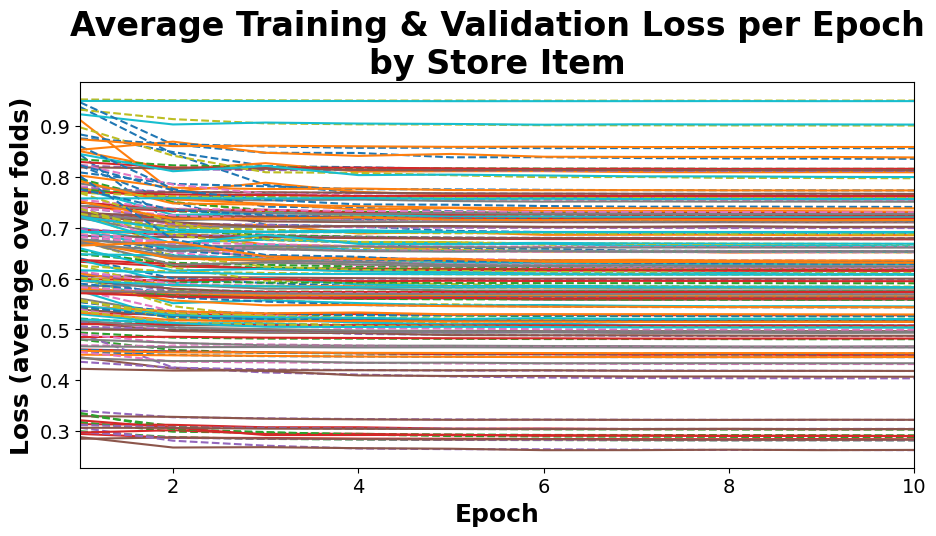

In [119]:
# 1) Compute per‐store, per‐epoch averages across folds
avg_hist = (
    history_df
      .groupby(['store_item','epoch'], as_index=False)
      .agg({
          'train_loss': 'mean',
          'val_loss':   'mean'
      })
)
avg_hist = avg_hist[avg_hist['epoch'] <= 10]


# 2) Plot
plt.figure(figsize=(10,6))


for sid, grp in avg_hist.groupby('store_item'):
    plt.plot(
        grp['epoch'], grp['train_loss'],
        linestyle='--', label=f'{sid} Train'
    )
    plt.plot(
        grp['epoch'], grp['val_loss'],
        linestyle='-', label=f'{sid} Val'
    )

plt.xlabel('Epoch', fontsize=18, fontweight="bold")
plt.ylabel('Loss (average over folds)', fontsize=18, fontweight="bold")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    'Average Training & Validation Loss per Epoch\nby Store Item',
    fontsize=24,       # or whatever size you prefer
    fontweight='bold'  # or weight='bold'
)

# limit x-axis
plt.xlim(1, 10)
# set x‑axis major ticks every 2
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(2))

# make legend font small
# plt.legend(
#     bbox_to_anchor=(1.01,1), loc='upper left', ncol=1,
#     fontsize=3       # or a numeric value like 8
# )
plt.tight_layout(pad=3.0)
plt.savefig("../output/figures/20251105_store_item_validation_loss.tiff", dpi=300, bbox_inches="tight")
plt.show()
plt.close() 



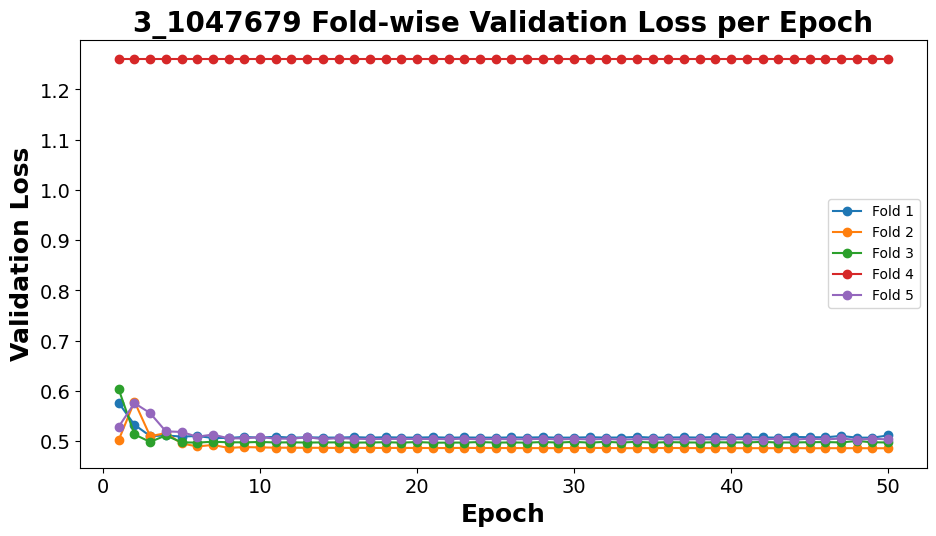

In [128]:
plt.figure(figsize=(10,6))
sid = "3_1047679"
h = history_df[history_df['store_item']==sid]

for fold, grp in h.groupby('fold'):
    # if fold == 4:
    #     continue
    plt.plot(
        grp['epoch'],
        grp['val_loss'],
        marker='o',
        label=f'Fold {fold}'
    )

plt.xlabel('Epoch', fontsize=18, fontweight="bold")
plt.ylabel('Validation Loss', fontsize=18, fontweight="bold")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    f'{sid} Fold‑wise Validation Loss per Epoch',
    fontsize=20,       
    fontweight='bold' 
)

plt.legend()
plt.tight_layout(pad=3.0)
plt.savefig("../output/figures/20251105_store_item_3_1047679_with_fold_4_validation_loss.tiff", dpi=300, bbox_inches="tight")
plt.show()
plt.close() 